<center>
    <h1>
Lasso
    </h1>
</center>

Given $x_1,...,x_n \in \mathbb{R}^d$ data vectors and $y_1,..,yn \in \mathbb{R}$ observations, we are searching
for regression parameters $w \in \mathbb{R}^d$ which fit data inputs to observations $y$ by minimizing their squared difference. In a high dimensional setting (when $n << d$) a $l_1$ norm penalty is often used on the regression coeffcients $w$ in order to enforce sparsity of the solution (so that $w$ will only have a few non-zeros entries). Such penalization has well known statistical properties, and makes the model both more interpretable, and faster at test time.

From an optimization point of view we want to solve the following problem called LASSO (which stands for Least Absolute Shrinkage Operator and Selection Operator)

$$ minimize \frac{1}{2} ||Xw-y||_2 ^2 + \lambda ||w||_1$$

in the variable w 2 Rd, where $X = (x^T_1,...,x^T_n)  \in R^{nxd}$, $y = (y_1,...,y_n) \in R^n$ and $\lambda > 0$ is a regularization parameter.

## Question 1

Derive the dual problem of LASSO and format it as a general Quadratic Problem as follows:
\begin{aligned}
& minimize \ \ \ v^T Q v + p^T v \\
& subject \ \ \ to \ \ \ Av \leq b
\end{aligned}

in variable $v \in R^n$, where $Q \geq 0$.



We can write the Lasso problem as:

\begin{aligned}
minimize \ \ \ \frac{1}{2} ||z||_2 ^2 + \lambda ||w||_1 \\
subject \ \ to z=Xw-y
\end{aligned}

The lagrangian of the problem can be seen as: 
    
$$L(v,w,z)= ||z||_2 ^2 + \lambda ||w||_1 + v^T (Xw-y-z)$$

The gradient respecto to $z$ is :
\begin{aligned}
\Delta_z= 2z - v \\
z=\frac{v}{2}
\end{aligned}

The dual can be written as 
\begin{aligned}
L_1(v)&=max_v -\frac{||v||_2 ^2}{4} - v^T y - Sup_w -\lambda ||w||_1 - v^T(Xw) \\
&=max_v -\frac{||v||_2 ^2}{4} - v^T y  - \lambda conjugate_{||||_1} \frac{-Xw}{\lambda} \\
&=max_v -\frac{||v||_2 ^2}{4} - v^T y \ \ \ subject \ \ to  \ \ Xw \leq \lambda \ \ \ -Xw \leq \lambda 
\end{aligned}

Then the dual is:

\begin{aligned}
max_v \frac{||v||_2^2}{2}+v^T y \\ 
subject \ \ to \ \ 
\begin{pmatrix}
X^T & 0 \\
0 & -X^T
\end{pmatrix} v \leq \lambda
\end{aligned}



## Question 2

Implement the barrier method to solve QP.

Write a function v seq = centering step(Q,p,A,b,t,v0,eps) which implements the Newton method to solve the centering step given the inputs $(Q, p, A, b)$, the barrier method parameter t (see lectures), initial variable $v_0$ an a target precision $\epsilon$. The function outputs the sequence of variables iterates $(vi)_i=1,...,n_{\epsilon}$ , where $n_{\epsilon}$ is the number of iterations to obtain the $\epsilon$ precision. Use a backtracking line search with appropriate parameters.    

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def f0(Q,p,v):
    ### Function to valuate the objective function of a QP
    
    ## Input
    # Q: a n × n-dimensional real symmetric matrix 
    # p: a real-valued, n-dimensional vector.
    # v: the point to evaluate, a n-dimensional real vector.
    
    ## Output
    # f0=the value of the objective function.
    
    f0=v.dot(Q).dot(v)+np.transpose(p).dot(v)
    return(f0)

def phi(A,b,v):
    ### Funtion to valuate the auxiliar function in the barrier method.
    
    # Input
    # A: a m × n-dimensional real matrix.
    # b: a m-dimensional real vector.
    # v: the point to evaluate, a n-dimensional real vector.
    
    # Output
    # phi= the value of the auxiliar function.
    phi=0.
    for i in range(0,A.shape[0]):
        phi-=np.log(-1.*(A[i,].dot(v)-b[i]))
    return(phi)

def centering_step(Q,p,A,b,t,v0,eps):
    ### Funtion to perform the centering step in the barrier method
     ## Input
    # Q: a n × n-dimensional real symmetric matrix 
    # p: a real-valued, n-dimensional vector.
    # A: a m × n-dimensional real matrix.
    # b: a m-dimensional real vector.
    # t: parameter of the penalization term in the barrier method. 
    # v0: initial feasible point, a n-dimensional real vector.
    # eps: desired precision. 
    
    ## Output 
    # v_seq: sequence of approximation points.
    
    ## Fixed values of alpha and beta for the backtracking algorithm
    alpha=0.01
    beta=0.5
    
    v_seq=[]
    v_old=v0
    v_seq.append(v0)
    ######### First Step #######
    ## Computation of gradient and hessian
    gradient_f0=(Q+np.transpose(Q)).dot(v_old)+p
    hessian_f0=Q+np.transpose(Q)
    gradient_phi=np.zeros(gradient_f0.size)
    hessian_phi=np.zeros(hessian_f0.shape)
    for i in np.arange(0,A.shape[0]):
        aux=np.array(A[i,])[np.newaxis]
        hessian_phi=(np.transpose(aux).dot(aux)/((A[i,].dot(v_old)-b[i])**2))+hessian_phi
        gradient_phi-=-(A[i,]/(A[i,].dot(v_old)-b[i]))
    gradient=t*gradient_f0+gradient_phi
    hessian=t*hessian_f0+hessian_phi
    
    ## newton step and decretment
    newton_step=-np.linalg.inv(hessian).dot(gradient)
    decretment=-gradient.dot(newton_step)
    
    ## Stop criteria 
    if((decretment/2.)>eps):
        s=1
        while(np.sum(A.dot(v_old+s*newton_step)>b)>0):  
            s=beta*s
        ## Backtracking
        while((t*f0(Q,p,v_old+s*newton_step)+phi(A,b,v_old+s*newton_step))>=
              (t*f0(Q,p,v_old)+phi(A,b,v_old)+alpha*s*gradient.dot(newton_step))):
            s=beta*s
        v_new=v_old+s*newton_step
    else: 
        return(v_seq)
    ######## Next steps ########
    ## Stop criteria 
    while((decretment/2.)>eps):
        v_old=v_new
        v_seq.append(v_old)
        
        ## Computation of gradient and hessian
        gradient_f0=(Q+np.transpose(Q)).dot(v_old)+p
        hessian_f0=Q+np.transpose(Q)
        gradient_phi=np.zeros(gradient_f0.size)
        hessian_phi=np.zeros(hessian_f0.shape)
        for i in np.arange(0,A.shape[0]):
            aux=np.array(A[i,])[np.newaxis]
            hessian_phi=(np.transpose(aux).dot(aux)/((A[i,].dot(v_old)-b[i])**2))+hessian_phi
            gradient_phi=-(A[i,]/(A[i,].dot(v_old)-b[i]))+gradient_phi
        gradient=t*gradient_f0+gradient_phi
        hessian=t*hessian_f0+hessian_phi
        
        ## Newton Step and decretment
        newton_step=-np.linalg.inv(hessian).dot(gradient)
        decretment=-gradient.dot(newton_step)
        s=1
        while(np.sum(A.dot(v_old+s*newton_step)>b)>0):  
            s=beta*s
        ##### Backtracking
        while(t*f0(Q,p,v_old+s*newton_step)+phi(A,b,v_old+s*newton_step)>=
              t*f0(Q,p,v_old)+phi(A,b,v_old)+alpha*s*gradient.dot(newton_step)):
                s=beta*s
        v_new=v_old+s*newton_step
    return(v_seq)   
   

Write a function v seq = barr method(Q,p,A,b,v0,eps) which implements the barrier method to solve QP using precedent function given the data inputs $(Q,p,A,b)$ a feasible point $v_0$ a precision criterion $\epsilon$. The function outputs the sequence of
variables iterates $(vi)i=1,...,n_{\epsilon}$ , where $n_{\epsilon}$ is the number of iterations to obtain the $\epsilon$ precision.

In [16]:
def barr_method(Q,p,A,b,v0,eps,mu):
    ### Funtion to perform the barrier method.
     ## Input
    # Q: a n × n-dimensional real symmetric matrix 
    # p: a real-valued, n-dimensional vector.
    # A: a m × n-dimensional real matrix.
    # b: a m-dimensional real vector. 
    # v0: initial feasible point, a n-dimensional real vector.
    # eps: desired precision. 
    # mu: value that controls the size of the jumps between interactions, real number>1
    
    ## Output 
    # v_seq: sequence of approximation points.
    v_seq=[]
    v_old=v0
    v_seq.append(v_old)
    ### Centering step
    m=A.shape[0]
    t=1
    v_aux=centering_step(Q,p,A,b,t,v_old,eps=1e-2)
    v_new=v_aux[-1]
    while(m/t>eps):
        v_old=v_new
        v_seq=v_seq+v_aux
        ### Centering step
        t=mu*t
        v_aux=centering_step(Q,p,A,b,t,v_old,eps=1e-2)
        v_new=v_aux[-1]
    return(v_seq)
def dual_to_original_problem(X,Y,v):
    ### Function to return the weights of the lasso problem from the dual's solution.
    ## Input
    ## X: dataset, a n × m-dimensional real matrix 
    ## Y: target values,a real-valued, a n-dimensional vector.
    ## v: the dual's solution , a n-dimensional real vector
    
    ## Output
    ## w: the weights of the lasso problem, a m-dimensional vector
    
    
    w=(np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X))).dot(Y+v)
    return(w)

## Question 3

Test your function on randomly generated matrices $X$ and observations $y$ with $\lambda = 10$.
Plot precision criterion and gap $f(v_t)-f^*$ in semilog scale (using the best value found for f as a surrogate for $f^*$). Repeat for different values of the barrier method parameter $\mu = 2, 15, 50, 100,...$ and check the impact on $w$. What would be an appropriate choice for $\mu$ ?

Initialization of X and Y

In [10]:
m=20
n=500
lamb=10
X=np.random.normal(size=m*n)
X.shape=(n,m)
Y=np.random.normal(size=n)

I deduce the parameters of the dual problem from the values given. 

In [11]:
Q=np.identity(X.shape[0])*(1/2)
p=Y
A=np.transpose(X)
A=np.concatenate([A,-A])
b=np.repeat(lamb,A.shape[0])

As $\lambda >0$ , I can fix the initial strict feasible value as 0.

In [12]:
v0=np.zeros(A.shape[1])

I performed the barrier method for diferent values of $\mu$ and with $\alpha=0.1$ and $\beta=0.5$ for the backtracking line search. I fixed the precision of the centering step at $10^{-2}$. 

In [13]:
mu=[2,15,50,100,200]
v=[barr_method(Q,p,A,b,v0,eps=1e-6,mu=i) for i in mu]

We can see how in all cases we have linear convergence. 
The number of iteraction needed to converge increases as $\mu$ decreases. This parameter has also an impact in the number of inter and outer interactions. The number of interactions of the centering step (inter interaction) increases as $\mu$ is larger,while the number of outer interaction reduces. 

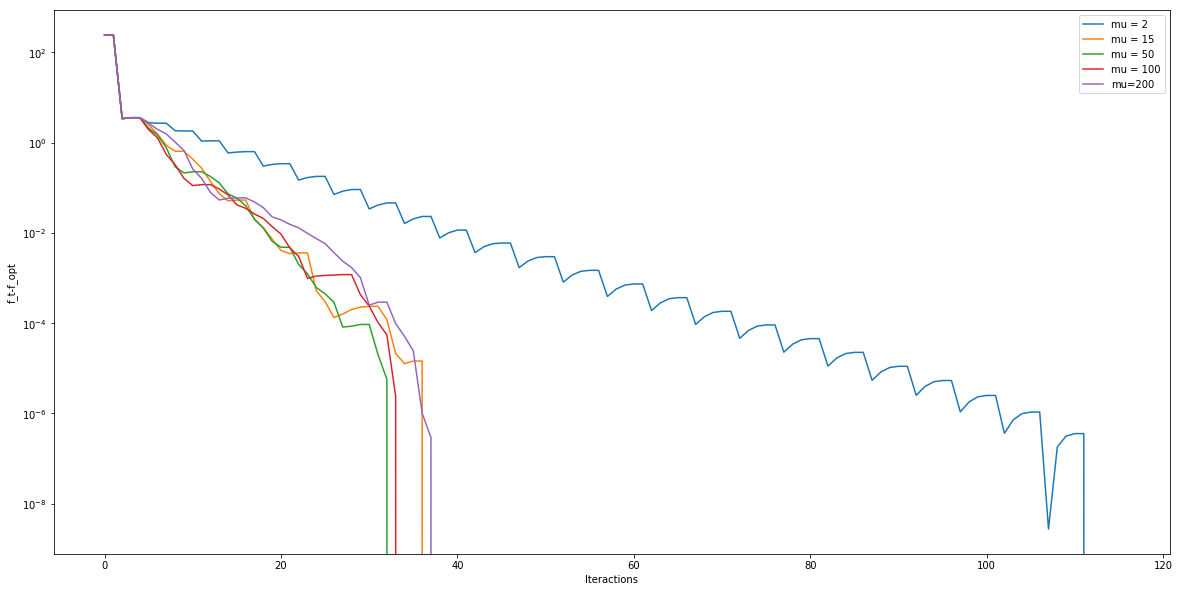

In [14]:
y=[]
for i in np.arange(0,len(mu)):
    y.append([f0(Q,p,j)-f0(Q,p,v[i][-1]) for j in v[i]])

plt.figure(figsize=(20,10))
for i in np.arange(0,len(mu)):
    plt.semilogy(np.arange(len(v[i])),y[i]) 
plt.legend(['mu = 2', 'mu = 15', 'mu = 50', 'mu = 100','mu=200'], loc='upper right')
plt.xlabel("Iteractions")
plt.ylabel("f_t-f_opt")
plt.show()

The number of iteractions affect the precision of the values of $w$. As I simulated Y idenpendently from X, I expect w to be close to 0. The results don't change too much with the different values of mu in this case. But in general, there will exist differences. And bigger values of $\mu$     could lead to poor results.

In [17]:
### Each array in the list shows the optimal value w found by each mu 
W=[dual_to_original_problem(X,Y,i[-1]) for i in v]
print(np.array(W))

[[ 2.52495433e-02 -9.98802649e-03 -2.94057667e-03 -2.51237703e-02
  -5.15542064e-03 -6.81911373e-09 -1.44746907e-08 -1.37289785e-08
  -9.29260785e-02 -7.05022126e-10  2.07799518e-08 -8.74259023e-10
  -2.31057311e-03  4.58623135e-09 -2.39696116e-02  2.94129016e-02
  -2.30021792e-02 -7.62232962e-02 -2.12836736e-02  9.98979544e-08]
 [ 2.52495533e-02 -9.98805340e-03 -2.94062328e-03 -2.51237708e-02
  -5.15542358e-03 -2.00876828e-08 -4.26390590e-08 -4.04424215e-08
  -9.29260907e-02 -2.07685739e-09  6.12121785e-08 -2.57538392e-09
  -2.31061931e-03  1.35100697e-08 -2.39696257e-02  2.94129095e-02
  -2.30021809e-02 -7.62233012e-02 -2.12836891e-02  2.94180471e-07]
 [ 2.52495656e-02 -9.98808685e-03 -2.94067941e-03 -2.51237713e-02
  -5.15542758e-03 -3.66097557e-08 -7.77087938e-08 -7.37055901e-08
  -9.29261060e-02 -3.78508942e-09  1.11556301e-07 -4.69363079e-09
  -2.31067499e-03  2.46220517e-08 -2.39696431e-02  2.94129194e-02
  -2.30021830e-02 -7.62233073e-02 -2.12837083e-02  5.35921114e-07]
 [ 2.52

In [18]:
[np.sum(np.abs(i)) for i in W]

[0.3375858130989542,
 0.33758631744230555,
 0.3375869414473393,
 0.3375942978759671,
 0.33758663768103175]

As we see before, given the properties of this problem, we expect that the duality gap is 0. In order to validate the solution obtained , I compared the duality gap for the different values of $\mu$. We can see that all of them give satisfying results. In this case, I would choose $\mu=100$ as it leads to the minimum number of interactions before convergence. In the general case, $\mu$ beetwen 15 and 20 is chosen.

In [19]:
f_primal=np.array([0.5*np.sum((X.dot(w)-Y)**2)+lamb*np.max(np.abs(w)) for w in W])
f_primal

array([240.48417319, 240.4841686 , 240.48416292, 240.48409581,
       240.48416568])

In [20]:
f_dual=np.array([-1*f0(Q,p,i[len(i)-1]) for i in v])
f_dual

array([242.93077002, 242.93076933, 242.93076848, 242.93075839,
       242.93076891])

In [21]:
duality_gap=np.abs(f_primal-f_dual)
duality_gap

array([2.44659682, 2.44660072, 2.44660555, 2.44666258, 2.44660323])